# 数据准备

In [1]:
import numpy as np
import pandas as pd

train_data = [  ['Sunny',   'Hot', 'High',  'Weak',  'No'],
                ['Sunny',   'Hot', 'High',  'Strong','No'],
                ['Overcast','Hot', 'High',  'Weak',  'Yes'],
                ['Rain',    'Mild','High',  'Weak',  'Yes'],
                ['Rain',    'Cool','Normal','Weak',  'Yes'],
                ['Rain',    'Cool','Normal','Strong','No'],
                ['Overcast','Cool','Normal','Strong','Yes'],
                ['Sunny',   'Mild','High',  'Weak',  'No'],
                ['Sunny',   'Cool','Normal','Weak',  'Yes'],
                ['Rain',    'Mild','Normal','Weak',  'Yes'],
                ['Sunny',   'Mild','Normal','Strong','Yes'],
                ['Overcast','Mild','High',  'Strong','Yes'],
                ['Overcast','Hot', 'Normal','Weak',  'Yes'],
                ['Rain',    'Mild','High',  'Strong','No']  ]

train_Data = pd.DataFrame(train_data,columns=['Outlook','Temperature','Humidity','Wind','PlayTennis'])
train_Data


,Outlook,Temperature,Humidity,Wind,PlayTennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [2]:
cols = train_Data.shape[1]
X_data = train_Data.iloc[:,:cols-1]
Y_data = train_Data.iloc[:,cols-1:]
featureNames = X_data.columns #返回所有列的名称

# 贝叶斯模型

In [3]:
def Naive_Bayes(X_data,Y_data):
    # step1 计算先验概率
    y=Y_data.values
    X=X_data.values
    y_unique=np.unique(y)#np.unique 找出所有不同元素，并放进一个数组
    prior_prob=np.zeros(len(y_unique))
    for i in range(len(y_unique)):
        prior_prob[i]=sum(y==y_unique[i])/len(y)

    # step2 计算似然（条件概率）
    condition_prob={} #创建dict存储条件概率

    for feat in featureNames:
        x_unique = list(set(X_data[feat])) #set()拿出X_data的feat这一列的所有不同的元素
        x_condition_prob = np.zeros((len(y_unique),len(x_unique)))
        '''
        feat=x1
        x_condition_prob
        P(A/0) P(B/0) P(C/0)
        P(A/1) P(B/1) P(C/1)

        feat=x2
        P(S/0) P(M/0) P(L/0)
        P(S/1) P(M/1) P(L/1)
        '''
        for j in range(len(y_unique)):
            for k in range(len(x_unique)):
                x_condition_prob[j,k]=\
                sum((X_data[feat]==x_unique[k]) & (Y_data.PlayTennis==y_unique[j]))/sum(y==y_unique[j])
                # sum((X_data[feat]==x_unique[k]) & (Y_data.y==y_unique[j]))/sum(y==y_unique[j])
                # p(X=feat|Y=y)=sum(X=feat,Y=y)/sum(Y=y)
        x_condition_prob = pd.DataFrame(x_condition_prob,columns=x_unique,index=y_unique)
        #feat -> 一张dataframe表
        condition_prob[feat] = x_condition_prob
    
    return prior_prob,condition_prob

# 训练

In [4]:
prior_prob ,condition_prob = Naive_Bayes(X_data,Y_data)
print(prior_prob)
print(condition_prob['Outlook'])
print(condition_prob['Temperature'])
print(condition_prob['Humidity'])
print(condition_prob['Wind'])

[0.35714286 0.64285714]
     Overcast      Rain     Sunny
No   0.000000  0.400000  0.600000
Yes  0.444444  0.333333  0.222222
          Hot      Mild      Cool
No   0.400000  0.400000  0.200000
Yes  0.222222  0.444444  0.333333
         High    Normal
No   0.800000  0.200000
Yes  0.333333  0.666667
         Weak    Strong
No   0.400000  0.600000
Yes  0.666667  0.333333


# 预测函数

In [5]:
#testData是Dataframe
def Prediction(testData,prior,condition_prob):
    numclass = prior.shape[0] #预测结果种类数
    numsample = testData.shape[0] # 测试集的样本个数
    featureNames = testData.columns #将各个特征值的索引提取出来
    post_prob = np.zeros((numsample,numclass)) #预测的结果
    '''
    post_pron
          p(yes) p(no)
    样本1
    样本2 
    ...

    '''
    for k in range(numsample):
        #第k个样本p(yes),p(no)
        prob_k = np.zeros((numclass,))
        for i in range(numclass):
            pri = prior[i] #p['yes'] or p['no']
            for feat in featureNames:
                #第k个样本在feat特征值下的值
                feat_val = testData[feat][k]
                cp = condition_prob[feat]
                #因为train_set里边是先No后Yes，所以先验概率prior中下标0存的是No
                if(i==0):
                    t='No'
                else:
                    t='Yes'
                cp_val = cp.loc[t,feat_val]
                pri *= cp_val
            prob_k[i] = pri
        
        #数据归一化，使p('yes')+p('no')=1
        prob = prob_k/np.sum(prob_k,axis = 0)
        post_prob[k,:] = prob
    return post_prob

# 预测

In [6]:
test_data = [['Sunny','Cool','High','Strong']]
test_Data = pd.DataFrame(test_data,columns=['Outlook','Temperature','Humidity','Wind'])
postPrior = Prediction(test_Data,prior_prob,condition_prob)
print(postPrior)


if(postPrior[0,0]>postPrior[0,1]):
    print('We cannot play tennis')
elif (postPrior[0,0]==postPrior[0,1]):
    print('uncertainty')
else:
    print('We can play tennis')

[[0.79541735 0.20458265]]
We cannot play tennis


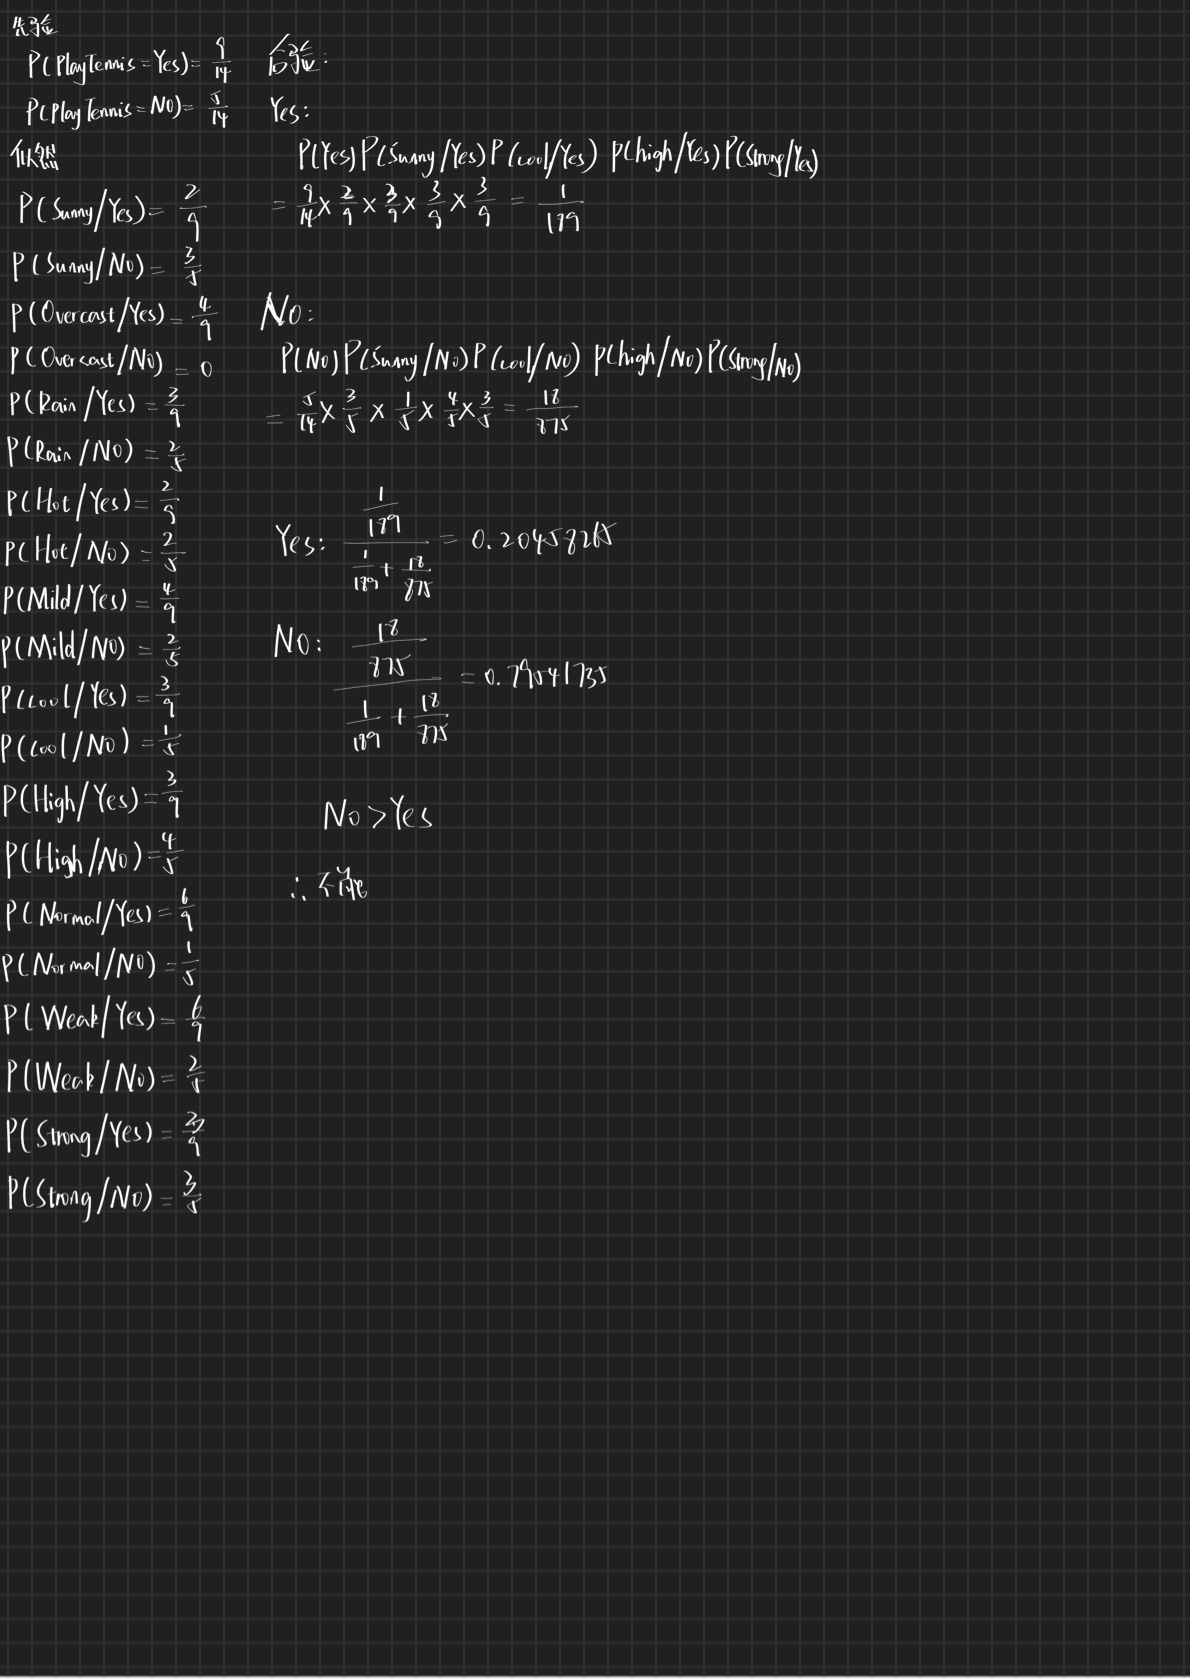